In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels


# univariate cnn example
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [2]:
import urllib
params ='DRIVER={SQL Server};SERVER=CL-AMILAH\AMILA;DATABASE=GSH;UID=Amila;Trusted_Connection=yes;'       
params = urllib.parse.quote_plus(params)

from sqlalchemy import create_engine
db = create_engine('mssql+pyodbc:///?odbc_connect=%s' % params)

In [3]:
sql = '''
SELECT inv.[ID] ,inv.SiteUID, [Date] , [OutletUID] ,ot.Name AS outlet ,pr.Description AS province , di.Description AS district 
, ar.Description AS Area , inv.[AgentUID] ,Concat(emp.FirstName ,' ' , emp.MiddleInitials , ' ', emp.LastName ) AS AgentName , inv.[DistributorUID] , d.Name AS distributor, [ItemUID] ,it.Description AS item, [UnitQty] 
, [UnitPrice] , [RetailUnitPrice] , [FreeQty] , [FreeCompanyQty] , [GrossValue]
,datename(YEAR, Date) AS Year
,datename(month, Date) AS MonthName
,MONTH(Date) AS Month
,datename(DAY, Date) AS Day
,DATEPART(DW,Date) AS WeekDay
,datename(WEEKDAY, Date) AS DateName
,DATEPART (hh,Date) as Hour

  FROM [GSH].[dbo].[vw_Invoice] inv
  LEFT JOIN [GSH].[dbo].[vw_InvoiceLine] invl
  ON inv.siteUID = invl.TxnInvoice_SiteUID AND inv.uid = invl.TxnInvoiceUID	
  LEFT JOIN [GSH].[dbo].[Item] it
  ON invl.ItemUID = it.UID
  LEFT JOIN [GSH].[dbo].[Outlet] ot
  ON inv.OutletUID = ot.UID
  LEFT JOIN [GSH].[dbo].[Area] pr
  ON ot.ProvinceUID = pr.UID
  LEFT JOIN [GSH].[dbo].[Area] di
  ON ot.DistrictUID = di.UID
  LEFT JOIN [GSH].[dbo].[Area] ar
  ON ot.AreaUID = ar.UID
  LEFT JOIN [GSH].[dbo].[Distributor] d
  ON inv.DistributorUID = d.UID
  LEFT JOIN [GSH].[dbo].[avLogin] avlg
  ON inv.AgentUID = avlg.BusinessUserUID
  LEFT JOIN [GSH].[dbo].[Employee] emp
  ON avlg.EmployeeUID = emp.UID
  WHERE inv.mpt_TypeEnum IN ( 21 , 44, 14, 1) AND inv.ExpiryDate IS NULL AND inv.SubmittedDate IS NOT NULL
  AND Date >= '2018-11-01' AND Date <= '2020-03-01' ;
'''

invoice_All = pd.read_sql_query(sql, db)

In [4]:
#disply all the columns
pd.set_option('display.max_columns', None)

In [5]:
invoice_All.head()

,ID,SiteUID,Date,OutletUID,outlet,province,district,Area,AgentUID,AgentName,DistributorUID,distributor,ItemUID,item,UnitQty,UnitPrice,RetailUnitPrice,FreeQty,FreeCompanyQty,GrossValue,Year,MonthName,Month,Day,WeekDay,DateName,Hour
0,CSO009300429,106,2018-11-10 10:38:11.057,975,Rewards Pharmacy,Western Province,Colombo,Palawatta,93,Amith Gayashan,9,Multy Drugs (Pvt) Ltd,4,Cosvate Cream 15gm,6.0,244.30,278.5,0.0,0.0,1465.8,2018,November,11,10,7,Saturday,10
1,CSO009300429,106,2018-11-10 10:38:11.057,975,Rewards Pharmacy,Western Province,Colombo,Palawatta,93,Amith Gayashan,9,Multy Drugs (Pvt) Ltd,9,Futop B Cream 10gm,2.0,386.00,440.0,0.0,0.0,772.0,2018,November,11,10,7,Saturday,10
2,CSO009400368,107,2018-11-10 10:44:58.090,983,Jeewaka Pharmacy,Western Province,Colombo,Thalawathugoda,94,Sumedha Kulathunga,9,Multy Drugs (Pvt) Ltd,129,Flexy Gel 20gm,20.0,243.85,278.0,0.0,0.0,4877.0,2018,November,11,10,7,Saturday,10
3,CSO009400368,107,2018-11-10 10:44:58.090,983,Jeewaka Pharmacy,Western Province,Colombo,Thalawathugoda,94,Sumedha Kulathunga,9,Multy Drugs (Pvt) Ltd,129,Flexy Gel 20gm,0.0,243.85,278.0,2.0,2.0,0.0,2018,November,11,10,7,Saturday,10
4,IN0071000004,0,2018-11-10 13:42:43.557,1790,Sethsiri Pharmacy,Western Province,Colombo,Hanwella,157,Samila Vidanage,23,New Kotiyakubura Pharmacy,9,Futop B Cream 10gm,10.0,386.00,440.0,0.0,0.0,3860.0,2018,November,11,10,7,Saturday,13


### Select the most selling product to identify the time series prediction

In [6]:
# select product sales records 
#Belcid Suspension 240ml top 1 product - based on unit qty
Sec_invoice_All = invoice_All.loc[invoice_All['ItemUID'] == 25]

In [7]:
Sec_invoice_All.head()

,ID,SiteUID,Date,OutletUID,outlet,province,district,Area,AgentUID,AgentName,DistributorUID,distributor,ItemUID,item,UnitQty,UnitPrice,RetailUnitPrice,FreeQty,FreeCompanyQty,GrossValue,Year,MonthName,Month,Day,WeekDay,DateName,Hour
651,CSO007700440,71,2018-11-11 14:20:03.197,3548,New Eleans Marketing,Eastern Province,Ampara,Akkaraipattu,77,Sandaruwan Nishan,1,Apex Med Pharmaceuticals,25,Belcid Suspension 240ml,1000.0,206.1,235.0,0.0,0.0,206100.0,2018,November,11,11,1,Sunday,14
739,CSO007700440,71,2018-11-11 14:20:03.197,3548,New Eleans Marketing,Eastern Province,Ampara,Akkaraipattu,77,Sandaruwan Nishan,1,Apex Med Pharmaceuticals,25,Belcid Suspension 240ml,0.0,238.7,272.0,300.0,300.0,0.0,2018,November,11,11,1,Sunday,14
824,CSO009400320,107,2018-11-07 14:43:16.980,679,Sam Pharmacy,Western Province,Colombo,Nugegoda,94,Sumedha Kulathunga,9,Multy Drugs (Pvt) Ltd,25,Belcid Suspension 240ml,20.0,238.7,272.0,0.0,0.0,4774.0,2018,November,11,7,4,Wednesday,14
825,CSO009400320,107,2018-11-07 14:43:16.980,679,Sam Pharmacy,Western Province,Colombo,Nugegoda,94,Sumedha Kulathunga,9,Multy Drugs (Pvt) Ltd,25,Belcid Suspension 240ml,0.0,238.7,272.0,4.0,6.0,0.0,2018,November,11,7,4,Wednesday,14
914,CSO009400371,107,2018-11-10 10:41:16.243,972,Pelawatta Pharmacy,Western Province,Colombo,Palawatta,94,Sumedha Kulathunga,9,Multy Drugs (Pvt) Ltd,25,Belcid Suspension 240ml,10.0,238.7,272.0,0.0,0.0,2387.0,2018,November,11,10,7,Saturday,10


In [8]:
#Aggregate data into weekly sum
sample=Sec_invoice_All[['Date','UnitQty']]
weekly=sample.resample('W', on='Date').sum()

In [9]:
weekly

,UnitQty
Date,
2018-11-04,307.0
2018-11-11,7505.0
2018-11-18,5488.0
2018-11-25,5944.0
2018-12-02,18655.0
...,...
2020-02-02,11494.0
2020-02-09,1554.0
2020-02-16,6313.0


In [10]:
weekly = weekly.reset_index()

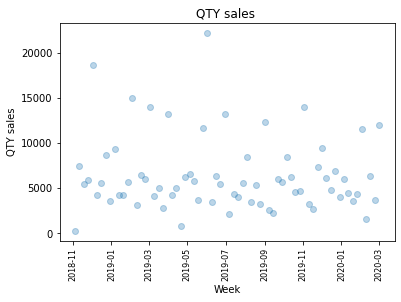

In [11]:
plt.scatter(weekly.Date , weekly.UnitQty , alpha=0.3,cmap='viridis')
plt.xlabel("Week")
plt.xticks (rotation='vertical', size=8)
plt.ylabel("QTY sales")
plt.title("QTY sales ")
plt.rcParams['figure.figsize'] = [15, 5]
plt.show()

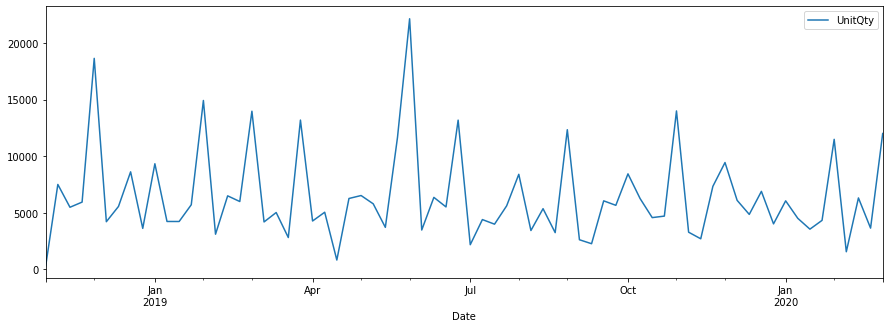

In [12]:
weekly.plot(kind = 'line', x = 'Date', y = 'UnitQty')
plt.show()

In [13]:
# remove z score > 3 
Sec_invoice_All = weekly[(np.abs(stats.zscore(weekly["UnitQty"])) < 3)]

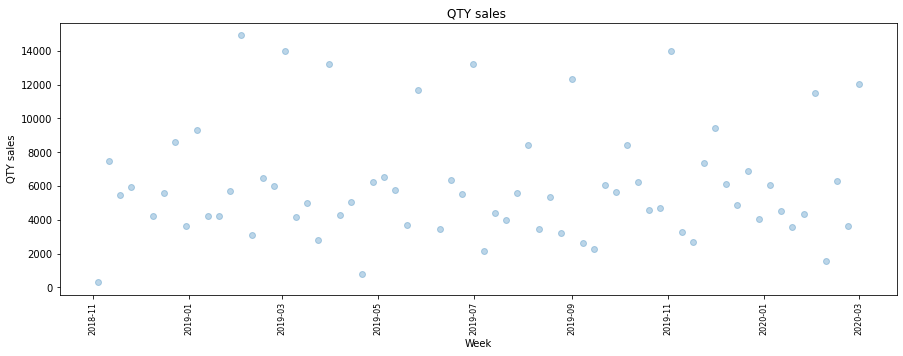

In [14]:
plt.scatter(Sec_invoice_All.Date , Sec_invoice_All.UnitQty , alpha=0.3,cmap='viridis')
plt.xlabel("Week")
plt.xticks (rotation='vertical', size=8)
plt.ylabel("QTY sales")
plt.title("QTY sales ")
plt.rcParams['figure.figsize'] = [15, 5]
plt.show()

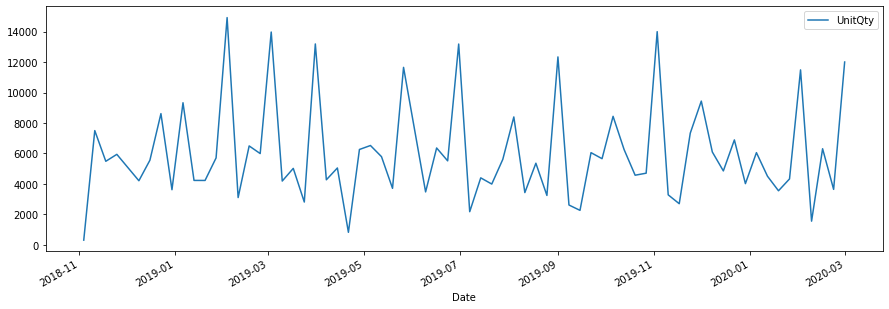

In [15]:
Sec_invoice_All.plot(kind = 'line', x = 'Date', y = 'UnitQty')
plt.show()

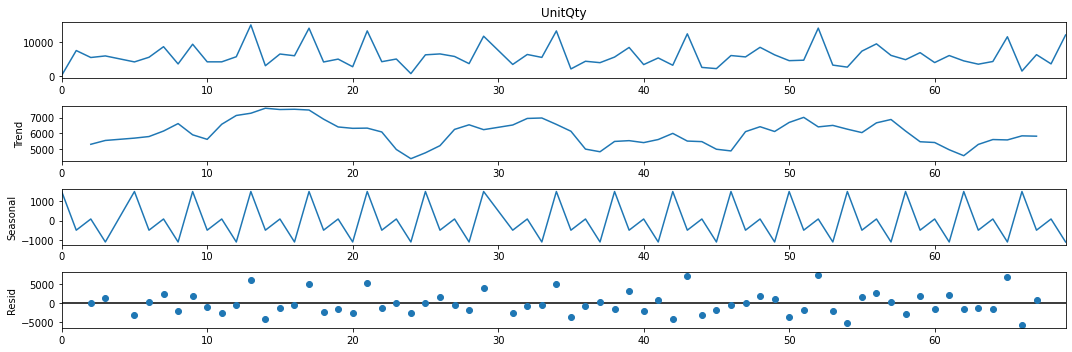

In [16]:
decomposition = seasonal_decompose(Sec_invoice_All['UnitQty'], period =4)
decomposition.plot()
plt.show()

In [17]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(Sec_invoice_All['UnitQty'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                 -3.620242
p-value                         0.005386
#Lags Used                      7.000000
Number of Observations Used    60.000000
Critical Value (1%)            -3.544369
Critical Value (5%)            -2.911073
Critical Value (10%)           -2.593190
dtype: float64


In [18]:
#create Date Table
def create_date_table2(start='2018-11-04', end='2020-03-01'):
    df = pd.DataFrame({"Date": pd.date_range(start, end)})
    return df

In [19]:
date_table = create_date_table2()

In [20]:
date_table.head(12)

,Date
0,2018-11-04
1,2018-11-05
2,2018-11-06
3,2018-11-07
4,2018-11-08
5,2018-11-09
6,2018-11-10
7,2018-11-11
8,2018-11-12
9,2018-11-13


In [21]:
# keep every 7th row
date_table = date_table.iloc[::7, :]

In [22]:
date_table

,Date
0,2018-11-04
7,2018-11-11
14,2018-11-18
21,2018-11-25
28,2018-12-02
...,...
455,2020-02-02
462,2020-02-09
469,2020-02-16
476,2020-02-23


In [23]:
#left Join with Weekly date table
Sec_inv_mis = date_table.merge(Sec_invoice_All, on='Date', how='left')

In [24]:
Sec_inv_mis.head(10)

,Date,UnitQty
0,2018-11-04,307.0
1,2018-11-11,7505.0
2,2018-11-18,5488.0
3,2018-11-25,5944.0
4,2018-12-02,NaN
5,2018-12-09,4210.0
6,2018-12-16,5559.0
7,2018-12-23,8620.0
8,2018-12-30,3620.0
9,2019-01-06,9335.0


In [25]:
#fill missing value with mean
Sec_inv_mis.fillna({"UnitQty":Sec_inv_mis['UnitQty'].mean().round(1)}, inplace=True)

In [26]:
Sec_inv_grp = Sec_inv_mis.sort_index()
Sec_inv_grp.head(10)

,Date,UnitQty
0,2018-11-04,307.0
1,2018-11-11,7505.0
2,2018-11-18,5488.0
3,2018-11-25,5944.0
4,2018-12-02,6011.2
5,2018-12-09,4210.0
6,2018-12-16,5559.0
7,2018-12-23,8620.0
8,2018-12-30,3620.0
9,2019-01-06,9335.0


In [27]:
#Pro1_inv_Nor_Sm = Pro1_inv_Nor_Sm.reset_index()
train = Sec_inv_grp.loc[Sec_inv_grp['Date'] <= "2019-11-30"]
train = train.set_index('Date')
## test set has been allocated train - 2 weeks ****** special case
test = Sec_inv_grp.loc[Sec_inv_grp['Date'] >= "2019-11-17"]
test = test.set_index('Date')

In [28]:
train = train.reset_index()
train_series = train['UnitQty'].squeeze()

In [29]:
# univariate data preparation
from numpy import array
 
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)
 
# define input sequence
raw_seq = train_series
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# summarize the data and print
#for i in range(len(X)):
#    print(X[i], y[i])

In [30]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [31]:
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [32]:
# fit model
model.fit(X, y, epochs=1000, verbose=0)

In [33]:
test = test.reset_index()
test_series = test['UnitQty'].squeeze()

In [34]:
## add dumy value to end of seris
test_series.idxmax()
new_index = test_series.idxmax()+1
test_series = test_series.append(pd.Series(0, index=[new_index]))

In [35]:

# define input sequence
raw_seq = test_series
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(raw_seq, n_steps)


In [36]:
predictions = []

In [37]:
# define input sequence
raw_seq = test_series
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# summarize the data
for i in range(len(X)):
    #print(X[i])
    # demonstrate prediction
    x_input = array(X[i])
    x_input = x_input.reshape((1, n_steps, n_features))
    yhat = model.predict(x_input, verbose=0)
    predictions.append(yhat[0][0])
    #print(yhat[0][0])

In [38]:
## purposely duplicated for indexes
train = Sec_inv_grp.loc[Sec_inv_grp['Date'] <= "2019-11-30"]
train = train.set_index('Date')
test = Sec_inv_grp.loc[Sec_inv_grp['Date'] > "2019-11-30"]
test = test.set_index('Date')

In [39]:
# get array data to DF with date index
Prd_Results = pd.DataFrame(data = predictions, columns = ['UnitQty'], index = test.index.copy())

In [40]:
# get array data to DF with date index
Prd_Results = pd.DataFrame(data = predictions, columns = ['UnitQty'], index = test.index.copy())

In [41]:
from sklearn.metrics import mean_squared_error
from math import sqrt
mse = mean_squared_error(test, Prd_Results)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 4506.216779


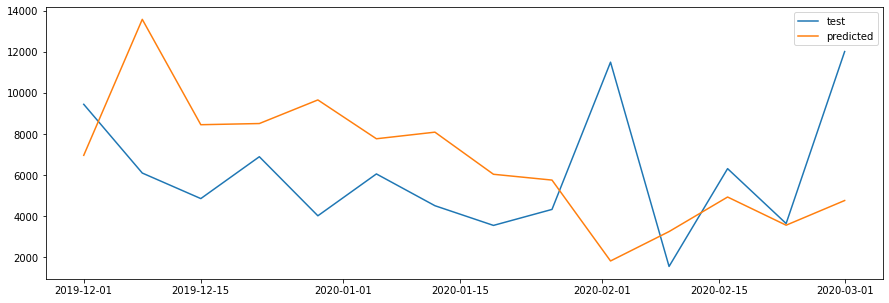

In [42]:
plt.plot(test)
plt.plot(Prd_Results)
plt.legend(['test', 'predicted'])